In [1]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt


#Agent的行動
class Actions(Enum):
    Sell = 0
    Buy = 1

#在Env裡面所代表的
class Positions(Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long

    
class TradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}
    
    #__init__為魔法函數，意義為：無論你願不願意，只要你執行TradingEnv，就會把__init__底下的資料執行，可以用作變數定義？
    def __init__(self, df, window_size): 
        assert df.ndim == 2 #判斷所輸入的df維度是否等於2

        self.seed() #隨機種子設定
        self.df = df #輸入df
        self.window_size = window_size #輸入Windows size
        self.open, self.close, self.high, self.low, self.volume, self.signal_features = self._process_data() #輸入【價錢, 特征資料】
        self.shape = (window_size, self.signal_features.shape[1]) #輸入【Windows size, 特征資料的長度】

        # spaces
        self.action_space = spaces.Discrete(len(Actions)) # 行動空間為：2（Sell、Buy）
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float64) #觀察空間最低和最高為無限（因為不知股票價錢為多少）

        # episode
        #「_」為私有化，即import的時候不會引入參數
        self._start_tick = self.window_size #開始日期：Windows_size設定的數字
        self._end_tick = len(self.close)-1 #結束日期：【價錢】的長度-1
        self._done = None 
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓        
        self._reward_history = []#記錄Reward獎勵，方便畫圖
        self._Total_profit = []#記錄Profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None

    #定義一個隨機種子   
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    #重設
    def reset(self):
        self._done = False #尚未完成
        self._current_tick = self._start_tick # Windows_size設定的數字
        self._last_trade_tick = self._current_tick -1 #Windows_size設定的數字-1
        self._position = Positions.Short #第一天交易必定為Short
        self._position_history = (self.window_size * [None]) + [self._position] #記錄位置
        self._total_reward = 0. #初始化的reward為：0
        self._total_profit = 1. #初始化的Profit為：1
        self._first_rendering = True
        self.history = {}
        return self._get_observation()

    #交易中的步驟
    def step(self, action):
        self._done = False #尚未完成動作
        
        
        #如果當前日期 = 完結日期，就結束步驟
        if self._current_tick == self._end_tick:
            self._done = True

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
#如果機器人進行買的動作，他的Position就會變成Long，反之亦然
        if(action == Actions.Buy.value):
            self._position = Positions.Long
#             print("action: ", action)
#             print("position: ", self._position)
        elif(action == Actions.Sell.value):
            self._position = Positions.Short
#             print("action: ", action)
#             print("position: ", self._position)
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑               
        self._last_trade_tick = self._current_tick      
        #記錄步驟
        self._position_history.append(self._position)
        
        #獎勵：調用計算獎勵的function，然後將它累積起來計算總和
        step_reward = self._calculate_reward(action)
        step_profit = self._update_profit(action)#記錄profit，方便畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
        self._reward_history.append(step_reward)#記錄Reward獎勵，方便畫圖
        self._Total_profit.append(step_profit)#記錄profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ 
        self._total_reward += step_reward
        #根據agent的action更新他的 profit
        
        
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        self._update_history(info)
        
        self._current_tick += 1 #當前日期+1

        return observation, step_reward, self._done, info

    #取得觀察值，觀察值為signal_features
    #若window_size為10
    #則使用0 ~ 9日的觀察值，下一次交易則使用1 ~ 10日的觀察值
    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]

    #更新歷史資料
    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    #render：將環境實體化，以股票交易為例即是畫圖
    def render(self, mode='human'):
        pass


    #畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓    
    def render_Close(self, mode='human'):
            window_ticks = np.arange(len(self._position_history))#[1,2,3,4,5,....]矩陣
            plt.plot(self.close)#根據收盤價進行繪畫

            short_ticks = []
            long_ticks = []
            # i：控制position_history的位置
            # tick：控制要塞進Long還是Short的位置
            #如果機器人在之前就是做Long的話就把它記錄在long_ticks裡面，反之亦然
            for i, tick in enumerate(window_ticks-1):
                if self._position_history[i] == Positions.Short:
                    short_ticks.append(tick)
                elif self._position_history[i] == Positions.Long:
                    long_ticks.append(tick)      

            del(short_ticks[0])

            plt.plot(short_ticks, self.close[short_ticks], 'ro', label = 'Short')#根據收盤價進行畫圖
            plt.plot(long_ticks, self.close[long_ticks], 'go', label = 'Long')#根據收盤價進行畫圖
            
            plt.legend()
            plt.title("Close", fontsize=20)
            plt.suptitle(
                "Total Reward: %.6f" % self._total_reward + ' ~ ' +
                "Total Profit: %.6f" % self._total_profit
            )
            print("↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓")
        
        
    #畫圖2   
    def render_Reward(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks-1):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)
        
        del(short_ticks[0])
        self._reward_history = np.array(self._reward_history)
        short_ticks = (np.array(short_ticks)-5).tolist()
        long_ticks = (np.array(long_ticks)-5).tolist()
        
        plt.bar(short_ticks,self._reward_history[short_ticks], color='r', label = 'Short')#根據獎勵進行繪畫
        plt.bar(long_ticks,self._reward_history[long_ticks], color='g', label = 'Long')#根據獎勵進行繪畫
            
        plt.legend()   
        plt.title("Reward", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(未含手續費) ↓↓↓")
        
        
    def render_TotalProfit(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        
        del self._Total_profit[-1]
        plt.plot(self._Total_profit)
        
        
#         short_ticks = []
#         long_ticks = []
#         for i, tick in enumerate(window_ticks-1):
#             if self._position_history[i] == Positions.Short:
#                 short_ticks.append(tick)
#             elif self._position_history[i] == Positions.Long:
#                 long_ticks.append(tick)
        
#         del(short_ticks[0])
#         self._Total_profit = np.array(self._Total_profit)
#         short_ticks = (np.array(short_ticks)-10).tolist()
#         long_ticks = (np.array(long_ticks)-10).tolist()
        
#         plt.plot(short_ticks, self._Total_profit[short_ticks], 'ro', label = 'Short')#根據獎勵進行畫圖
#         plt.plot(long_ticks, self._Total_profit[long_ticks], 'go', label = 'Long')#根據獎勵進行畫圖
            
#         plt.legend() 

        plt.title("TotalProfit", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓")

        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑         
        


    
    
    #關閉環境，即關閉畫圖    
    def close(self):
        plt.close()

    #保存圖片
    def save_rendering(self, filepath):
        plt.savefig(filepath)

    #暫停畫圖
    def pause_rendering(self):
        plt.show()

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _process_data(self):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _calculate_reward(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _update_profit(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def max_possible_profit(self):  # trade fees are ignored
        pass

In [2]:
import numpy as np

class StocksEnv(TradingEnv):
    

    def __init__(self, df, window_size, frame_bound):
        assert len(frame_bound) == 2 #判斷所輸入的df維度是否等於2

        self.frame_bound = frame_bound #輸入範圍值
        super().__init__(df, window_size)

        self.trade_fee_percent = 0.001425+0.003
        #https://rich01.com/what-is-next-day-trading/
        
    #資料處理
    def _process_data(self):
        open = self.df.loc[:, 'open'].to_numpy() #prices：開市價
        close = self.df.loc[:, 'close'].to_numpy() #prices：收盤價
        high = self.df.loc[:, 'high'].to_numpy() #prices：最高
        low = self.df.loc[:, 'low'].to_numpy() #prices：最低
        volume = self.df.loc[:, 'volume'].to_numpy() #prices：成交量
        close[self.frame_bound[0] - self.window_size] # validate index (TODO: Improve validation)#驗證資料：10-10
        close = close[self.frame_bound[0]-self.window_size:self.frame_bound[1]]#【10-10:5600】

        diff = np.insert(np.diff(close), 0, 0)#計算價差【今天 - 昨天】
        signal_features = np.column_stack((close, diff))#默認的signal_features為：收盤價，價差

        return open, close ,high, low, volume, signal_features

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
    #計算獎勵
    def _calculate_reward(self, action):
        step_reward = 0
        price_diff = 0
        
        if(self._current_tick < self._end_tick):
            if(action == Actions.Buy.value):
                current_price = self.close[self._current_tick]#【今天收盤】
                last_trade_price = self.open[self._current_tick+1]#【明天開盤】
                price_diff = last_trade_price - current_price#【明天開盤 - 今天收盤】

            elif(action == Actions.Sell.value):
                current_price = self.close[self._current_tick]#【今天收盤】
                last_trade_price = self.open[self._current_tick+1]#【明天開盤】
                price_diff = -(last_trade_price - current_price)#【-(明天開盤 - 今天收盤)】
        
        step_reward =  step_reward + price_diff
        
        return step_reward


    def _update_profit(self, action):
        
        long_profit_percentage = 0.0
        short_profit_percentage = 0.0
        Total_long_profit_percentage = 0.0
        Total_short_profit_percentage = 0.0
        
        step_profit = 0
        if(self._current_tick < self._end_tick):
            if(action == Actions.Buy.value):
                current_price = self.close[self._current_tick]#【今天收盤】
                last_trade_price = self.open[self._current_tick+1]#【明天開盤】
                long_profit_percentage = ((last_trade_price - current_price)/current_price) - self.trade_fee_percent
                self._total_profit += long_profit_percentage
            elif(action == Actions.Sell.value):

                current_price = self.close[self._current_tick]#【今天收盤】
                last_trade_price = self.open[self._current_tick+1]#【明天開盤】
                short_profit_percentage = ((-(last_trade_price - current_price)) / current_price) - self.trade_fee_percent
                self._total_profit += short_profit_percentage   
                
        step_profit += self._total_profit #記錄profit，方便畫圖
        return step_profit#記錄profit，方便畫圖
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑  
                
    #https://github.com/AminHP/gym-anytrading/blob/master/README.ipynb
    #不論交易費用如何，agent在股票交易中所獲得的profit
    def max_possible_profit(self):
        pass

In [3]:
# import gym_anytrading
import numpy as np
import pandas as pd
import quantstats as qs
from stable_baselines import A2C

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



C:\Users\cherr\.conda\envs\Python37TensorFlow20V2\lib\site-packages\stable_baselines\__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [4]:
from yahoo_fin import stock_info as si
from sklearn.preprocessing import Normalizer
if isinstance('2330.TW', str):
    # load it from yahoo_fin library
    df = si.get_data('2330.TW')
df = df.dropna()#丟棄空值
df = df.reset_index()

#---------------------------------------------------------------------------
#定義參數

open = df['open']
close = df['close']
high = df['high']
low = df['low']
UpLine_max = []
UpLine = [] #上引線
DownLine_min = []
DownLine = [] #下引線
UpMean = []#計算RSI——上漲平均5天
DownMean = []#計算RSI——下跌平均5天
RSI = []#計算RSI
#---------------------------------------------------------------------------
#上引線；下引線

for i in range(close.size):
    UpLine_max.append(max(open[i], close[i]))
for i in range(close.size):
    UpLine.append(high[i] - UpLine_max[i])#上影線
for i in range(close.size):
    DownLine_min.append(min(open[i], close[i]))
for i in range(close.size):
    DownLine.append(DownLine_min[i] - low[i])#下影線
#---------------------------------------------------------------------------
#RSI

UpDownValue = close - close.shift(1) #計算漲跌值
Only_UpValue = pd.Series(index=UpDownValue.index, data=UpDownValue[UpDownValue>0])#將上漲日子篩出
Only_UpValue = Only_UpValue.fillna(0)#下跌的日子為0
Only_DownValue = pd.Series(index=UpDownValue.index, data=-UpDownValue[UpDownValue<0])#將下跌日子篩出
Only_DownValue = Only_DownValue.fillna(0)#上漲的日子為0
for i in range(13, len(Only_UpValue)+1):#由第六日開始，直到現在
    UpMean.append(np.mean(Only_UpValue.values[i-12:i]))#計算出最近五日的平均，因為有補0，所以可以計算出。
    DownMean.append(np.mean(Only_DownValue.values[i-12:i]))#計算出最近五日的平均
for i in range(len(UpMean)):
    RSI.append( (UpMean[i] / ( UpMean[i] + DownMean[i] )) * 100  )#計算RSI
RSI = pd.Series(index = close.index[12:], data = RSI) #轉換格式
#---------------------------------------------------------------------------
#FH；FL
FH = ((high - open) / open) #FH
FL = ((open - low) / open) #FL
FH = pd.DataFrame(FH, columns=['FH'])#FH參數
FL = pd.DataFrame(FL, columns=['FL'])#FL參數
#---------------------------------------------------------------------------
# KD
K = []
D = []
K_Value = []
D_Value = []
def RSV(df):
    df['MinLow'] = df['low'].rolling(9, min_periods=9).min()#9天最低位
    df['MinLow'].fillna(value = df['low'].expanding().min(), inplace = True)#填滿NA
    df['MaxHigh'] = df['high'].rolling(9, min_periods=9).max()#9天最高位
    df['MaxHigh'].fillna(value = df['high'].expanding().max(), inplace = True)#填滿NA
    df['RSV'] = (df['close'] - df['MinLow']) / (df['MaxHigh'] - df['MinLow']) * 100 #計算RSV
    return df
RSV_df = RSV(df)#使用RSV函數計算
RSV = RSV_df['RSV']#獲得RSV
for i in range(len(RSV)):
    if i<=9 :
        K.append(50)
        D.append(50)
    elif i > 9:
        K.append((K[i-1] * 2/3) + (1/3 * RSV[i]))
        D.append((D[i-1] * 2/3) + (1/3 * K[i]))
K_Value = pd.Series(index = close.index[0:], data = K) #轉換格式
D_Value = pd.Series(index = close.index[0:], data = D) #轉換格式
#---------------------------------------------------------------------------
# MACD
DIF = []
MACD = []
ShortEMA=close.ewm(span=12,adjust=False).mean()#12日移動平均
LongEMA=close.ewm(span=26,adjust=False).mean()#26日移動平均
FastLine_DIF=ShortEMA-LongEMA#DIF = （12日移動平均 - 26日移動平均）
SlowLine_MACD=FastLine_DIF.ewm(span=9,adjust=False).mean()#取DIF數值得到9日移動平均
FastLine_DIF = pd.DataFrame(FastLine_DIF)#轉換格式
SlowLine_MACD = pd.DataFrame(SlowLine_MACD)#轉換格式
FastLine_DIF = FastLine_DIF.rename(columns={'close':'DIF'})#轉換格式
SlowLine_MACD = SlowLine_MACD.rename(columns={'close':'MACD'})#轉換格式
#---------------------------------------------------------------------------                                                             
#BBands
def BBands(df,Day=20,Times=2):#20天平均, 2倍標準差
    Up_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Mid_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Down_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    SD=pd.Series(0.0,index=df.index)#建立全0的陣列
    
    for i in range(Day-1,len(df)):#19~5600   
        Mid_Track[i]=np.mean(df[i-(Day-1):(i+1)])#中軌 = 0-20平均 -> 1-21平均 -> 2-22平均...（移動平均線）
        SD[i]=np.std(df[i-(Day-1):(i+1)])#0-20標準差 -> 1-21標準差 ->2-22標準差...（標準差）
        Up_Track[i]=Mid_Track[i]+(Times*SD[i])#上軌 = 中軌+（2倍標準差）
        Down_Track[i]=Mid_Track[i]-(Times*SD[i])#下軌 = 中軌-（2倍標準差）
        
        #慢慢地將上半部分建立的全0函式更新
        df_BBands=pd.DataFrame({'Up_Track':Up_Track[(Day-1):],#由第19日開始載入布林通道（上）
                             'Mid_Track':Mid_Track[(Day-1):],#由第19日開始載入布林通道（中）
                             'Down_Track':Down_Track[(Day-1):]#由第19日開始載入布林通道（下）
                            })
    return(df_BBands)
BBands_Up_Mid_Down_Trak = BBands(close, 20, 2)
#---------------------------------------------------------------------------
#合拼df
df2330 = pd.merge(df, FH,left_index=True,right_index=True) #合拼FH
df2330 = pd.merge(df2330, FL,left_index=True,right_index=True) #合拼FL
df2330 = pd.merge(df2330, pd.DataFrame(UpLine, columns=['UpLine']),left_index=True,right_index=True) #合併上影線
df2330 = pd.merge(df2330, pd.DataFrame(DownLine, columns=['DownLine']),left_index=True,right_index=True) #合併下影線
df2330 = pd.merge(df2330, pd.DataFrame(RSI, columns=['RSI']),left_index=True,right_index=True) #合併RSI
df2330 = pd.merge(df2330, pd.DataFrame(K_Value, columns=['K_Value']),left_index=True,right_index=True) #合併K值
df2330 = pd.merge(df2330, pd.DataFrame(D_Value, columns=['D_Value']),left_index=True,right_index=True) #合併D值
df2330 = pd.merge(df2330, pd.DataFrame(FastLine_DIF),left_index=True,right_index=True) #合併DIF
df2330 = pd.merge(df2330, pd.DataFrame(SlowLine_MACD),left_index=True,right_index=True) #合併MACD
df2330 = pd.merge(df2330,BBands_Up_Mid_Down_Trak,left_index=True,right_index=True) #合併布林通道
df2330.index = range(len(df2330))#更新index

# 是否將特徵資料標準化？

In [5]:
#---------------------------------------------------------------------------
normalizer = Normalizer()#創建標準化函數
df2330_AllFeatures = df2330[['MinLow','MaxHigh','RSV','FH','FL','UpLine','DownLine','RSI','K_Value','D_Value','DIF','MACD','Up_Track','Mid_Track','Down_Track']]#取得需要標準化的特徵
df2330_FeaturesNormalize = normalizer.fit_transform(df2330_AllFeatures)#進行標準化
df2330_FeaturesNormalize = pd.DataFrame(df2330_FeaturesNormalize)#將array變成df
df2330_FeaturesNormalize = df2330_FeaturesNormalize.rename(columns={0:'MinLow',1:'MaxHigh',2:'RSV',
                                                      3:'FH',4:'FL',
                                                      5:'UpLine',6:'DownLine',
                                                      7:'RSI',
                                                      8:'K_Value',9:'D_Value',
                                                      10:'DIF',11:'MACD',
                                                      12:'Up_Track',13:'Mid_Track',14:'Down_Track'})#更改名字
df2330_OriginData = df2330[['index','open','high','low','close','adjclose','volume','ticker']]#取得市場基本資料
df2330_Normalized = pd.merge(df2330_OriginData, df2330_FeaturesNormalize, left_index=True,right_index=True) #基本資料與標準化後特徵資料合併
df2330 = df2330_Normalized
#---------------------------------------------------------------------------

#---------------------------------------------------------------------------
#輸出最終Dataframe
df2330

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,UpLine,DownLine,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track
0,2000-01-31,77.474449,79.822517,77.083290,79.430984,40.596722,1.680593e+11,2330.TW,0.309921,0.361288,...,0.001713,0.001712,0.340351,0.351078,0.349870,0.011103,0.006873,0.354890,0.319509,0.284129
1,2000-02-01,80.213676,80.213676,78.648293,79.039825,40.396805,1.530819e+11,2330.TW,0.314672,0.366827,...,0.000000,0.001740,0.327941,0.341312,0.350593,0.011484,0.007879,0.363530,0.326493,0.289457
2,2000-02-02,79.039825,79.039825,79.039825,79.039825,40.396805,0.000000e+00,2330.TW,0.319760,0.370711,...,0.000000,0.000000,0.315521,0.333172,0.347261,0.011640,0.008698,0.370338,0.331708,0.293078
3,2000-02-03,79.039825,79.039825,79.039825,79.039825,40.396805,0.000000e+00,2330.TW,0.329770,0.372094,...,0.000000,0.000000,0.344641,0.316836,0.337983,0.011578,0.009300,0.374065,0.335061,0.296056
4,2000-02-04,79.039825,79.039825,79.039825,79.039825,40.396805,0.000000e+00,2330.TW,0.339458,0.376977,...,0.000000,0.000000,0.349164,0.300968,0.328601,0.011512,0.009840,0.380023,0.342048,0.304073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5646,2022-09-08,473.000000,475.000000,472.000000,475.000000,472.278656,2.793155e+07,2330.TW,0.423638,0.453257,...,0.000000,0.000898,0.028192,0.007732,0.010367,-0.005827,-0.002053,0.480573,0.451798,0.423024
5647,2022-09-12,485.000000,491.000000,485.000000,486.500000,483.712769,2.159721e+07,2330.TW,0.423915,0.453553,...,0.004042,0.000000,0.036534,0.018312,0.013020,-0.005704,-0.002784,0.479664,0.450724,0.421784
5648,2022-09-13,495.000000,495.000000,491.000000,493.000000,490.175537,1.650704e+07,2330.TW,0.424165,0.453820,...,0.000000,0.001797,0.037444,0.031278,0.019111,-0.005078,-0.003244,0.477420,0.449642,0.421863
5649,2022-09-14,478.500000,482.500000,476.000000,480.000000,477.250000,2.264571e+07,2330.TW,0.427568,0.448856,...,0.002265,0.002265,0.030653,0.031298,0.023276,-0.005502,-0.003717,0.478336,0.451212,0.424088


# 查找DF的標籤

In [6]:
dfStartDate_Train = df2330[(df2330['index']=='2007-01-02')].index.values
dfStartDate_Train = dfStartDate_Train[0]
dfStartDate_Train

1793

In [7]:
dfEndDate_Train = df2330[(df2330['index']=='2022-06-30')].index.values
dfEndDate_Train = dfEndDate_Train[0]
dfEndDate_Train

5596

In [8]:
df2330[dfStartDate_Train:dfEndDate_Train+1]

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,UpLine,DownLine,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track
1793,2007-01-02,66.790359,66.987381,66.297806,66.691849,37.359818,26292533.0,2330.TW,0.298317,0.314018,...,0.000924,0.001847,0.330271,0.375104,0.318968,0.003697,0.003264,0.314696,0.304389,0.294083
1794,2007-01-03,66.790359,67.676956,66.494827,66.987381,37.525372,42463339.0,2330.TW,0.302538,0.320747,...,0.003268,0.001401,0.325475,0.382450,0.342472,0.004142,0.003468,0.319093,0.308001,0.296909
1795,2007-01-04,66.691849,67.085892,66.593338,66.691849,37.359818,22444226.0,2330.TW,0.312725,0.331035,...,0.001927,0.000482,0.283559,0.383284,0.363400,0.004437,0.003751,0.329130,0.317832,0.306534
1796,2007-01-05,66.494827,66.691849,65.509720,65.903763,36.918346,30905222.0,2330.TW,0.326070,0.345162,...,0.001005,0.002010,0.329041,0.355903,0.371239,0.004386,0.004006,0.343108,0.331370,0.319633
1797,2007-01-08,65.115677,65.509720,64.721634,64.820145,36.311314,24350615.0,2330.TW,0.355820,0.376074,...,0.002190,0.000547,0.317538,0.298569,0.369181,0.004038,0.004299,0.373754,0.360966,0.348177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5592,2022-06-24,489.500000,492.500000,485.500000,486.500000,483.712769,27911980.0,2330.TW,0.421797,0.448757,...,0.002609,0.000870,0.009466,0.004935,0.007676,-0.010773,-0.007574,0.491998,0.453649,0.415300
5593,2022-06-27,496.000000,506.000000,495.500000,498.500000,495.644012,37909718.0,2330.TW,0.422116,0.449096,...,0.006528,0.000435,0.021099,0.015926,0.010430,-0.010414,-0.008147,0.491810,0.452621,0.413433
5594,2022-06-28,496.000000,500.000000,496.000000,497.500000,494.649750,15274062.0,2330.TW,0.423326,0.450384,...,0.002182,0.000000,0.024078,0.022380,0.014433,-0.010106,-0.008557,0.490394,0.451758,0.413123
5595,2022-06-29,496.000000,498.500000,491.000000,491.000000,488.186981,30533789.0,2330.TW,0.426897,0.445382,...,0.002201,0.000000,0.027083,0.023429,0.017513,-0.010265,-0.008956,0.488750,0.452533,0.416316


In [9]:
def my_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size #start = 5 - 5
    end = frame_bound[1] #end = 5600 
    close = df.loc[:, 'close'].to_numpy()[start:end]#抓取Close
    open = df.loc[:, 'open'].to_numpy()[start:end]#抓取open
    high = df.loc[:, 'high'].to_numpy()[start:end]#抓取high
    low = df.loc[:, 'low'].to_numpy()[start:end]#抓取low
    volnume = df.loc[:, 'volume'].to_numpy()[start:end]#抓取volume
    signal_features = df.loc[:, ['K_Value', 'D_Value']].to_numpy()[start:end]#抓取特徵資料
    return open, close, high, low, volnume, signal_features


class MyStocksEnv(StocksEnv):
    
    def __init__(self, open, close, high, low, volnume, signal_features, **kwargs):
        self._open = open
        self._close = close
        self._high = high
        self._low = low
        self._volnume = volnume
        self._signal_features = signal_features
        super().__init__(**kwargs)

    def _process_data(self):
        return self._open, self._close, self._high, self._low, self._volnume, self._signal_features

    
open, close, high, low, volume, signal_features = my_process_data(df=df2330, window_size=5, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, signal_features, df=df2330, window_size=5, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#「環境」整合

In [10]:
policy_kwargs = dict(net_arch=[256, 'lstm', dict(vf=[128], pi=[128])])#要傳遞給policy的參數

model = A2C('MlpLstmPolicy', env, verbose=1, policy_kwargs=policy_kwargs, gamma=0.1, learning_rate=0.0000001)
# model = A2C('MlpLstmPolicy', env, verbose=1)
#policy: The policy model to use (MlpPolicy, CnnPolicy, …)""
#verbose: 0 no output, 1 info, 2 debug
#policy_kwargs: additional arguments to be passed to the policy on creation要傳遞給policy的參數
model.learn(total_timesteps=1000000)

Wrapping the env in a DummyVecEnv.




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


---------------------------------
| explained_variance | 0.00746  |
| fps                | 0        |
| nupdates           | 1        |
| policy_entropy     | 0.693    |
| total_timesteps    | 5        |
| value_loss         | 0.139    |
---------------------------------
----------------------------------
| explained_variance | -2.98e-06 |
| fps                | 35        |
| nupdates           | 100       |
| policy_entropy     | 0.693     |
| total_timesteps    | 500       |
| value_loss         | 6.8       |
----------------------------------
---------------------------------
| explained_variance |

----------------------------------
| explained_variance | -3.35e-05 |
| fps                | 86        |
| nupdates           | 1500      |
| policy_entropy     | 0.693     |
| total_timesteps    | 7500      |
| value_loss         | 46.6      |
----------------------------------
---------------------------------
| explained_variance | -0.00301 |
| fps                | 87       |
| nupdates           | 1600     |
| policy_entropy     | 0.693    |
| total_timesteps    | 8000     |
| value_loss         | 1.01     |
---------------------------------
---------------------------------
| explained_variance | -0.00632 |
| fps                | 87       |
| nupdates           | 1700     |
| policy_entropy     | 0.693    |
| total_timesteps    | 8500     |
| value_loss         | 0.191    |
---------------------------------
---------------------------------
| explained_variance | 0.00135  |
| fps                | 88       |
| nupdates           | 1800     |
| policy_entropy     | 0.693    |
| tota

---------------------------------
| explained_variance | 5.77e-05 |
| fps                | 81       |
| nupdates           | 4500     |
| policy_entropy     | 0.693    |
| total_timesteps    | 22500    |
| value_loss         | 251      |
---------------------------------
---------------------------------
| explained_variance | -0.00556 |
| fps                | 80       |
| nupdates           | 4600     |
| policy_entropy     | 0.693    |
| total_timesteps    | 23000    |
| value_loss         | 0.6      |
---------------------------------
---------------------------------
| explained_variance | 0.00107  |
| fps                | 80       |
| nupdates           | 4700     |
| policy_entropy     | 0.693    |
| total_timesteps    | 23500    |
| value_loss         | 0.38     |
---------------------------------
---------------------------------
| explained_variance | -0.0027  |
| fps                | 80       |
| nupdates           | 4800     |
| policy_entropy     | 0.693    |
| total_timest

---------------------------------
| explained_variance | -0.00032 |
| fps                | 75       |
| nupdates           | 7500     |
| policy_entropy     | 0.693    |
| total_timesteps    | 37500    |
| value_loss         | 8.24     |
---------------------------------
----------------------------------
| explained_variance | -2.37e-05 |
| fps                | 75        |
| nupdates           | 7600      |
| policy_entropy     | 0.693     |
| total_timesteps    | 38000     |
| value_loss         | 75.6      |
----------------------------------
---------------------------------
| explained_variance | -0.00292 |
| fps                | 75       |
| nupdates           | 7700     |
| policy_entropy     | 0.693    |
| total_timesteps    | 38500    |
| value_loss         | 6.64     |
---------------------------------
---------------------------------
| explained_variance | -0.00272 |
| fps                | 75       |
| nupdates           | 7800     |
| policy_entropy     | 0.693    |
| tota

----------------------------------
| explained_variance | -6.22e-05 |
| fps                | 73        |
| nupdates           | 10500     |
| policy_entropy     | 0.693     |
| total_timesteps    | 52500     |
| value_loss         | 9.75      |
----------------------------------
----------------------------------
| explained_variance | -0.000113 |
| fps                | 73        |
| nupdates           | 10600     |
| policy_entropy     | 0.693     |
| total_timesteps    | 53000     |
| value_loss         | 14.4      |
----------------------------------
---------------------------------
| explained_variance | 0.00434  |
| fps                | 73       |
| nupdates           | 10700    |
| policy_entropy     | 0.693    |
| total_timesteps    | 53500    |
| value_loss         | 1.41     |
---------------------------------
---------------------------------
| explained_variance | 0.0024   |
| fps                | 73       |
| nupdates           | 10800    |
| policy_entropy     | 0.693    

---------------------------------
| explained_variance | 0.00198  |
| fps                | 72       |
| nupdates           | 13500    |
| policy_entropy     | 0.693    |
| total_timesteps    | 67500    |
| value_loss         | 3.66     |
---------------------------------
----------------------------------
| explained_variance | -7.13e-05 |
| fps                | 72        |
| nupdates           | 13600     |
| policy_entropy     | 0.693     |
| total_timesteps    | 68000     |
| value_loss         | 26.6      |
----------------------------------
---------------------------------
| explained_variance | 0.00715  |
| fps                | 72       |
| nupdates           | 13700    |
| policy_entropy     | 0.693    |
| total_timesteps    | 68500    |
| value_loss         | 0.07     |
---------------------------------
---------------------------------
| explained_variance | -0.0122  |
| fps                | 72       |
| nupdates           | 13800    |
| policy_entropy     | 0.693    |
| tota

----------------------------------
| explained_variance | -0.000911 |
| fps                | 72        |
| nupdates           | 16600     |
| policy_entropy     | 0.693     |
| total_timesteps    | 83000     |
| value_loss         | 6.84      |
----------------------------------
----------------------------------
| explained_variance | -3.73e-05 |
| fps                | 72        |
| nupdates           | 16700     |
| policy_entropy     | 0.693     |
| total_timesteps    | 83500     |
| value_loss         | 45.4      |
----------------------------------
---------------------------------
| explained_variance | -0.00447 |
| fps                | 72       |
| nupdates           | 16800    |
| policy_entropy     | 0.693    |
| total_timesteps    | 84000    |
| value_loss         | 0.984    |
---------------------------------
---------------------------------
| explained_variance | -0.00102 |
| fps                | 72       |
| nupdates           | 16900    |
| policy_entropy     | 0.693    

---------------------------------
| explained_variance | 0.000654 |
| fps                | 71       |
| nupdates           | 19600    |
| policy_entropy     | 0.693    |
| total_timesteps    | 98000    |
| value_loss         | 10.4     |
---------------------------------
---------------------------------
| explained_variance | 0.000214 |
| fps                | 71       |
| nupdates           | 19700    |
| policy_entropy     | 0.693    |
| total_timesteps    | 98500    |
| value_loss         | 14.5     |
---------------------------------
---------------------------------
| explained_variance | -0.00536 |
| fps                | 71       |
| nupdates           | 19800    |
| policy_entropy     | 0.693    |
| total_timesteps    | 99000    |
| value_loss         | 0.377    |
---------------------------------
----------------------------------
| explained_variance | -0.000279 |
| fps                | 71        |
| nupdates           | 19900     |
| policy_entropy     | 0.693     |
| total_t

---------------------------------
| explained_variance | 0.000873 |
| fps                | 71       |
| nupdates           | 22600    |
| policy_entropy     | 0.693    |
| total_timesteps    | 113000   |
| value_loss         | 2        |
---------------------------------
---------------------------------
| explained_variance | 0.00174  |
| fps                | 71       |
| nupdates           | 22700    |
| policy_entropy     | 0.693    |
| total_timesteps    | 113500   |
| value_loss         | 4.28     |
---------------------------------
----------------------------------
| explained_variance | -4.08e-05 |
| fps                | 71        |
| nupdates           | 22800     |
| policy_entropy     | 0.693     |
| total_timesteps    | 114000    |
| value_loss         | 13.1      |
----------------------------------
---------------------------------
| explained_variance | -0.00217 |
| fps                | 71       |
| nupdates           | 22900    |
| policy_entropy     | 0.693    |
| tota

---------------------------------
| explained_variance | 0.00447  |
| fps                | 71       |
| nupdates           | 25600    |
| policy_entropy     | 0.693    |
| total_timesteps    | 128000   |
| value_loss         | 1.22     |
---------------------------------
----------------------------------
| explained_variance | -0.000389 |
| fps                | 71        |
| nupdates           | 25700     |
| policy_entropy     | 0.693     |
| total_timesteps    | 128500    |
| value_loss         | 4.6       |
----------------------------------
---------------------------------
| explained_variance | -3.7e-06 |
| fps                | 71       |
| nupdates           | 25800    |
| policy_entropy     | 0.693    |
| total_timesteps    | 129000   |
| value_loss         | 103      |
---------------------------------
---------------------------------
| explained_variance | -0.00477 |
| fps                | 71       |
| nupdates           | 25900    |
| policy_entropy     | 0.693    |
| tota

---------------------------------
| explained_variance | 0.000563 |
| fps                | 71       |
| nupdates           | 28600    |
| policy_entropy     | 0.693    |
| total_timesteps    | 143000   |
| value_loss         | 6.11     |
---------------------------------
----------------------------------
| explained_variance | -0.000911 |
| fps                | 71        |
| nupdates           | 28700     |
| policy_entropy     | 0.693     |
| total_timesteps    | 143500    |
| value_loss         | 9.28      |
----------------------------------
---------------------------------
| explained_variance | 6.19e-05 |
| fps                | 71       |
| nupdates           | 28800    |
| policy_entropy     | 0.693    |
| total_timesteps    | 144000   |
| value_loss         | 85       |
---------------------------------
---------------------------------
| explained_variance | 0.000153 |
| fps                | 71       |
| nupdates           | 28900    |
| policy_entropy     | 0.693    |
| tota

---------------------------------
| explained_variance | -0.00375 |
| fps                | 71       |
| nupdates           | 31600    |
| policy_entropy     | 0.693    |
| total_timesteps    | 158000   |
| value_loss         | 1.22     |
---------------------------------
---------------------------------
| explained_variance | 0.0015   |
| fps                | 71       |
| nupdates           | 31700    |
| policy_entropy     | 0.693    |
| total_timesteps    | 158500   |
| value_loss         | 1.46     |
---------------------------------
---------------------------------
| explained_variance | 0.000606 |
| fps                | 71       |
| nupdates           | 31800    |
| policy_entropy     | 0.693    |
| total_timesteps    | 159000   |
| value_loss         | 9.56     |
---------------------------------
----------------------------------
| explained_variance | -5.13e-06 |
| fps                | 71        |
| nupdates           | 31900     |
| policy_entropy     | 0.693     |
| total_t

---------------------------------
| explained_variance | 0.000713 |
| fps                | 71       |
| nupdates           | 34700    |
| policy_entropy     | 0.693    |
| total_timesteps    | 173500   |
| value_loss         | 1.84     |
---------------------------------
---------------------------------
| explained_variance | -0.00012 |
| fps                | 71       |
| nupdates           | 34800    |
| policy_entropy     | 0.693    |
| total_timesteps    | 174000   |
| value_loss         | 1.37     |
---------------------------------
---------------------------------
| explained_variance | 1.48e-05 |
| fps                | 71       |
| nupdates           | 34900    |
| policy_entropy     | 0.693    |
| total_timesteps    | 174500   |
| value_loss         | 13       |
---------------------------------
---------------------------------
| explained_variance | -0.00335 |
| fps                | 70       |
| nupdates           | 35000    |
| policy_entropy     | 0.693    |
| total_timest

----------------------------------
| explained_variance | -4.07e-05 |
| fps                | 70        |
| nupdates           | 37700     |
| policy_entropy     | 0.693     |
| total_timesteps    | 188500    |
| value_loss         | 3.35      |
----------------------------------
---------------------------------
| explained_variance | 0.00248  |
| fps                | 70       |
| nupdates           | 37800    |
| policy_entropy     | 0.693    |
| total_timesteps    | 189000   |
| value_loss         | 0.765    |
---------------------------------
---------------------------------
| explained_variance | 0.00168  |
| fps                | 70       |
| nupdates           | 37900    |
| policy_entropy     | 0.693    |
| total_timesteps    | 189500   |
| value_loss         | 9.12     |
---------------------------------
----------------------------------
| explained_variance | -0.000251 |
| fps                | 70        |
| nupdates           | 38000     |
| policy_entropy     | 0.693     |
|

---------------------------------
| explained_variance | -0.00073 |
| fps                | 70       |
| nupdates           | 40700    |
| policy_entropy     | 0.693    |
| total_timesteps    | 203500   |
| value_loss         | 0.396    |
---------------------------------
----------------------------------
| explained_variance | -0.000371 |
| fps                | 70        |
| nupdates           | 40800     |
| policy_entropy     | 0.693     |
| total_timesteps    | 204000    |
| value_loss         | 4.07      |
----------------------------------
---------------------------------
| explained_variance | 0.000106 |
| fps                | 70       |
| nupdates           | 40900    |
| policy_entropy     | 0.693    |
| total_timesteps    | 204500   |
| value_loss         | 6        |
---------------------------------
---------------------------------
| explained_variance | 3.25e-05 |
| fps                | 70       |
| nupdates           | 41000    |
| policy_entropy     | 0.693    |
| tota

---------------------------------
| explained_variance | -0.0068  |
| fps                | 70       |
| nupdates           | 43700    |
| policy_entropy     | 0.693    |
| total_timesteps    | 218500   |
| value_loss         | 0.996    |
---------------------------------
----------------------------------
| explained_variance | -0.000686 |
| fps                | 70        |
| nupdates           | 43800     |
| policy_entropy     | 0.693     |
| total_timesteps    | 219000    |
| value_loss         | 3.22      |
----------------------------------
---------------------------------
| explained_variance | 0.000959 |
| fps                | 70       |
| nupdates           | 43900    |
| policy_entropy     | 0.693    |
| total_timesteps    | 219500   |
| value_loss         | 1.93     |
---------------------------------
----------------------------------
| explained_variance | -4.07e-05 |
| fps                | 70        |
| nupdates           | 44000     |
| policy_entropy     | 0.693     |
|

---------------------------------
| explained_variance | -0.0128  |
| fps                | 70       |
| nupdates           | 46700    |
| policy_entropy     | 0.693    |
| total_timesteps    | 233500   |
| value_loss         | 0.142    |
---------------------------------
---------------------------------
| explained_variance | 0.00186  |
| fps                | 70       |
| nupdates           | 46800    |
| policy_entropy     | 0.693    |
| total_timesteps    | 234000   |
| value_loss         | 0.874    |
---------------------------------
---------------------------------
| explained_variance | 0.0029   |
| fps                | 70       |
| nupdates           | 46900    |
| policy_entropy     | 0.693    |
| total_timesteps    | 234500   |
| value_loss         | 2.11     |
---------------------------------
----------------------------------
| explained_variance | -0.000414 |
| fps                | 70        |
| nupdates           | 47000     |
| policy_entropy     | 0.693     |
| total_t

---------------------------------
| explained_variance | 0.000293 |
| fps                | 70       |
| nupdates           | 49800    |
| policy_entropy     | 0.693    |
| total_timesteps    | 249000   |
| value_loss         | 1.11     |
---------------------------------
---------------------------------
| explained_variance | 0.00351  |
| fps                | 70       |
| nupdates           | 49900    |
| policy_entropy     | 0.693    |
| total_timesteps    | 249500   |
| value_loss         | 1.47     |
---------------------------------
----------------------------------
| explained_variance | -4.86e-05 |
| fps                | 70        |
| nupdates           | 50000     |
| policy_entropy     | 0.693     |
| total_timesteps    | 250000    |
| value_loss         | 38.4      |
----------------------------------
----------------------------------
| explained_variance | -0.000326 |
| fps                | 70        |
| nupdates           | 50100     |
| policy_entropy     | 0.693     |
|

---------------------------------
| explained_variance | 0.00039  |
| fps                | 70       |
| nupdates           | 52800    |
| policy_entropy     | 0.693    |
| total_timesteps    | 264000   |
| value_loss         | 1.91     |
---------------------------------
---------------------------------
| explained_variance | 0.00525  |
| fps                | 70       |
| nupdates           | 52900    |
| policy_entropy     | 0.693    |
| total_timesteps    | 264500   |
| value_loss         | 1.53     |
---------------------------------
---------------------------------
| explained_variance | 0.00123  |
| fps                | 70       |
| nupdates           | 53000    |
| policy_entropy     | 0.693    |
| total_timesteps    | 265000   |
| value_loss         | 2.29     |
---------------------------------
---------------------------------
| explained_variance | -0.00114 |
| fps                | 70       |
| nupdates           | 53100    |
| policy_entropy     | 0.693    |
| total_timest

---------------------------------
| explained_variance | -0.00869 |
| fps                | 70       |
| nupdates           | 55800    |
| policy_entropy     | 0.693    |
| total_timesteps    | 279000   |
| value_loss         | 0.477    |
---------------------------------
---------------------------------
| explained_variance | 0.0029   |
| fps                | 70       |
| nupdates           | 55900    |
| policy_entropy     | 0.693    |
| total_timesteps    | 279500   |
| value_loss         | 0.522    |
---------------------------------
---------------------------------
| explained_variance | -0.00018 |
| fps                | 70       |
| nupdates           | 56000    |
| policy_entropy     | 0.693    |
| total_timesteps    | 280000   |
| value_loss         | 0.709    |
---------------------------------
---------------------------------
| explained_variance | 0.00241  |
| fps                | 70       |
| nupdates           | 56100    |
| policy_entropy     | 0.693    |
| total_timest

----------------------------------
| explained_variance | -0.000314 |
| fps                | 70        |
| nupdates           | 58800     |
| policy_entropy     | 0.693     |
| total_timesteps    | 294000    |
| value_loss         | 0.219     |
----------------------------------
----------------------------------
| explained_variance | -2.67e-05 |
| fps                | 70        |
| nupdates           | 58900     |
| policy_entropy     | 0.693     |
| total_timesteps    | 294500    |
| value_loss         | 1.77      |
----------------------------------
---------------------------------
| explained_variance | -0.0043  |
| fps                | 70       |
| nupdates           | 59000    |
| policy_entropy     | 0.693    |
| total_timesteps    | 295000   |
| value_loss         | 0.251    |
---------------------------------
---------------------------------
| explained_variance | 0.00218  |
| fps                | 70       |
| nupdates           | 59100    |
| policy_entropy     | 0.693    

----------------------------------
| explained_variance | -0.000142 |
| fps                | 70        |
| nupdates           | 61800     |
| policy_entropy     | 0.693     |
| total_timesteps    | 309000    |
| value_loss         | 0.0802    |
----------------------------------
---------------------------------
| explained_variance | -0.0019  |
| fps                | 70       |
| nupdates           | 61900    |
| policy_entropy     | 0.693    |
| total_timesteps    | 309500   |
| value_loss         | 1.43     |
---------------------------------
---------------------------------
| explained_variance | -0.00024 |
| fps                | 70       |
| nupdates           | 62000    |
| policy_entropy     | 0.693    |
| total_timesteps    | 310000   |
| value_loss         | 0.549    |
---------------------------------
---------------------------------
| explained_variance | 0.000644 |
| fps                | 70       |
| nupdates           | 62100    |
| policy_entropy     | 0.693    |
| tota

---------------------------------
| explained_variance | 0.00277  |
| fps                | 70       |
| nupdates           | 64800    |
| policy_entropy     | 0.692    |
| total_timesteps    | 324000   |
| value_loss         | 0.156    |
---------------------------------
---------------------------------
| explained_variance | 0.00349  |
| fps                | 70       |
| nupdates           | 64900    |
| policy_entropy     | 0.692    |
| total_timesteps    | 324500   |
| value_loss         | 0.955    |
---------------------------------
---------------------------------
| explained_variance | 0.0024   |
| fps                | 70       |
| nupdates           | 65000    |
| policy_entropy     | 0.693    |
| total_timesteps    | 325000   |
| value_loss         | 1.32     |
---------------------------------
---------------------------------
| explained_variance | -0.00363 |
| fps                | 70       |
| nupdates           | 65100    |
| policy_entropy     | 0.693    |
| total_timest

----------------------------------
| explained_variance | -0.000476 |
| fps                | 70        |
| nupdates           | 67800     |
| policy_entropy     | 0.693     |
| total_timesteps    | 339000    |
| value_loss         | 8.45      |
----------------------------------
---------------------------------
| explained_variance | 0.00159  |
| fps                | 70       |
| nupdates           | 67900    |
| policy_entropy     | 0.693    |
| total_timesteps    | 339500   |
| value_loss         | 0.138    |
---------------------------------
---------------------------------
| explained_variance | -0.0019  |
| fps                | 70       |
| nupdates           | 68000    |
| policy_entropy     | 0.693    |
| total_timesteps    | 340000   |
| value_loss         | 1.08     |
---------------------------------
----------------------------------
| explained_variance | -0.000334 |
| fps                | 70        |
| nupdates           | 68100     |
| policy_entropy     | 0.693     |
|

---------------------------------
| explained_variance | -0.00043 |
| fps                | 70       |
| nupdates           | 70800    |
| policy_entropy     | 0.693    |
| total_timesteps    | 354000   |
| value_loss         | 0.155    |
---------------------------------
---------------------------------
| explained_variance | 0.00559  |
| fps                | 70       |
| nupdates           | 70900    |
| policy_entropy     | 0.693    |
| total_timesteps    | 354500   |
| value_loss         | 0.176    |
---------------------------------
---------------------------------
| explained_variance | 0.000469 |
| fps                | 70       |
| nupdates           | 71000    |
| policy_entropy     | 0.692    |
| total_timesteps    | 355000   |
| value_loss         | 0.616    |
---------------------------------
---------------------------------
| explained_variance | -0.0102  |
| fps                | 70       |
| nupdates           | 71100    |
| policy_entropy     | 0.693    |
| total_timest

---------------------------------
| explained_variance | -0.0132  |
| fps                | 70       |
| nupdates           | 73800    |
| policy_entropy     | 0.693    |
| total_timesteps    | 369000   |
| value_loss         | 0.658    |
---------------------------------
---------------------------------
| explained_variance | -8.2e-05 |
| fps                | 70       |
| nupdates           | 73900    |
| policy_entropy     | 0.692    |
| total_timesteps    | 369500   |
| value_loss         | 7.78     |
---------------------------------
---------------------------------
| explained_variance | -0.00403 |
| fps                | 70       |
| nupdates           | 74000    |
| policy_entropy     | 0.692    |
| total_timesteps    | 370000   |
| value_loss         | 0.169    |
---------------------------------
---------------------------------
| explained_variance | -0.00673 |
| fps                | 70       |
| nupdates           | 74100    |
| policy_entropy     | 0.693    |
| total_timest

----------------------------------
| explained_variance | -2.35e-05 |
| fps                | 70        |
| nupdates           | 76800     |
| policy_entropy     | 0.693     |
| total_timesteps    | 384000    |
| value_loss         | 81.4      |
----------------------------------
----------------------------------
| explained_variance | -0.000547 |
| fps                | 70        |
| nupdates           | 76900     |
| policy_entropy     | 0.692     |
| total_timesteps    | 384500    |
| value_loss         | 4.84      |
----------------------------------
---------------------------------
| explained_variance | 0.00472  |
| fps                | 70       |
| nupdates           | 77000    |
| policy_entropy     | 0.692    |
| total_timesteps    | 385000   |
| value_loss         | 0.118    |
---------------------------------
----------------------------------
| explained_variance | -0.000785 |
| fps                | 70        |
| nupdates           | 77100     |
| policy_entropy     | 0.692

----------------------------------
| explained_variance | -0.000537 |
| fps                | 70        |
| nupdates           | 79800     |
| policy_entropy     | 0.693     |
| total_timesteps    | 399000    |
| value_loss         | 40.7      |
----------------------------------
---------------------------------
| explained_variance | 0.0133   |
| fps                | 70       |
| nupdates           | 79900    |
| policy_entropy     | 0.692    |
| total_timesteps    | 399500   |
| value_loss         | 0.0339   |
---------------------------------
---------------------------------
| explained_variance | 9.01e-05 |
| fps                | 70       |
| nupdates           | 80000    |
| policy_entropy     | 0.692    |
| total_timesteps    | 400000   |
| value_loss         | 10.8     |
---------------------------------
---------------------------------
| explained_variance | -0.00198 |
| fps                | 70       |
| nupdates           | 80100    |
| policy_entropy     | 0.692    |
| tota

----------------------------------
| explained_variance | -0.000273 |
| fps                | 70        |
| nupdates           | 82800     |
| policy_entropy     | 0.693     |
| total_timesteps    | 414000    |
| value_loss         | 2.62      |
----------------------------------
----------------------------------
| explained_variance | -0.000184 |
| fps                | 70        |
| nupdates           | 82900     |
| policy_entropy     | 0.693     |
| total_timesteps    | 414500    |
| value_loss         | 13.3      |
----------------------------------
---------------------------------
| explained_variance | 0.000752 |
| fps                | 70       |
| nupdates           | 83000    |
| policy_entropy     | 0.693    |
| total_timesteps    | 415000   |
| value_loss         | 1.01     |
---------------------------------
---------------------------------
| explained_variance | 0.00143  |
| fps                | 70       |
| nupdates           | 83100    |
| policy_entropy     | 0.692    

----------------------------------
| explained_variance | -0.000437 |
| fps                | 70        |
| nupdates           | 85800     |
| policy_entropy     | 0.693     |
| total_timesteps    | 429000    |
| value_loss         | 6.88      |
----------------------------------
----------------------------------
| explained_variance | -5.48e-06 |
| fps                | 70        |
| nupdates           | 85900     |
| policy_entropy     | 0.693     |
| total_timesteps    | 429500    |
| value_loss         | 111       |
----------------------------------
---------------------------------
| explained_variance | -0.00236 |
| fps                | 70       |
| nupdates           | 86000    |
| policy_entropy     | 0.693    |
| total_timesteps    | 430000   |
| value_loss         | 2.25     |
---------------------------------
---------------------------------
| explained_variance | 0.000498 |
| fps                | 70       |
| nupdates           | 86100    |
| policy_entropy     | 0.692    

---------------------------------
| explained_variance | 0.00032  |
| fps                | 70       |
| nupdates           | 88800    |
| policy_entropy     | 0.693    |
| total_timesteps    | 444000   |
| value_loss         | 5.34     |
---------------------------------
---------------------------------
| explained_variance | 1.67e-06 |
| fps                | 70       |
| nupdates           | 88900    |
| policy_entropy     | 0.693    |
| total_timesteps    | 444500   |
| value_loss         | 30.2     |
---------------------------------
----------------------------------
| explained_variance | -2.99e-05 |
| fps                | 70        |
| nupdates           | 89000     |
| policy_entropy     | 0.693     |
| total_timesteps    | 445000    |
| value_loss         | 105       |
----------------------------------
----------------------------------
| explained_variance | -0.000773 |
| fps                | 70        |
| nupdates           | 89100     |
| policy_entropy     | 0.692     |
|

----------------------------------
| explained_variance | -0.000894 |
| fps                | 70        |
| nupdates           | 91800     |
| policy_entropy     | 0.693     |
| total_timesteps    | 459000    |
| value_loss         | 2.22      |
----------------------------------
---------------------------------
| explained_variance | 0.00074  |
| fps                | 70       |
| nupdates           | 91900    |
| policy_entropy     | 0.693    |
| total_timesteps    | 459500   |
| value_loss         | 2.16     |
---------------------------------
----------------------------------
| explained_variance | -0.000163 |
| fps                | 70        |
| nupdates           | 92000     |
| policy_entropy     | 0.693     |
| total_timesteps    | 460000    |
| value_loss         | 23.8      |
----------------------------------
---------------------------------
| explained_variance | -0.00609 |
| fps                | 70       |
| nupdates           | 92100    |
| policy_entropy     | 0.692    

----------------------------------
| explained_variance | -0.000512 |
| fps                | 70        |
| nupdates           | 94800     |
| policy_entropy     | 0.693     |
| total_timesteps    | 474000    |
| value_loss         | 2.03      |
----------------------------------
---------------------------------
| explained_variance | -0.00208 |
| fps                | 70       |
| nupdates           | 94900    |
| policy_entropy     | 0.693    |
| total_timesteps    | 474500   |
| value_loss         | 2.68     |
---------------------------------
----------------------------------
| explained_variance | -0.000111 |
| fps                | 70        |
| nupdates           | 95000     |
| policy_entropy     | 0.693     |
| total_timesteps    | 475000    |
| value_loss         | 17        |
----------------------------------
----------------------------------
| explained_variance | -2.35e-05 |
| fps                | 70        |
| nupdates           | 95100     |
| policy_entropy     | 0.693

---------------------------------
| explained_variance | 0.00947  |
| fps                | 70       |
| nupdates           | 97800    |
| policy_entropy     | 0.693    |
| total_timesteps    | 489000   |
| value_loss         | 0.318    |
---------------------------------
----------------------------------
| explained_variance | -3.53e-05 |
| fps                | 69        |
| nupdates           | 97900     |
| policy_entropy     | 0.693     |
| total_timesteps    | 489500    |
| value_loss         | 3.29      |
----------------------------------
---------------------------------
| explained_variance | 0.000422 |
| fps                | 70       |
| nupdates           | 98000    |
| policy_entropy     | 0.693    |
| total_timesteps    | 490000   |
| value_loss         | 11.2     |
---------------------------------
---------------------------------
| explained_variance | 0.000592 |
| fps                | 70       |
| nupdates           | 98100    |
| policy_entropy     | 0.693    |
| tota

---------------------------------
| explained_variance | 0.0037   |
| fps                | 69       |
| nupdates           | 100800   |
| policy_entropy     | 0.693    |
| total_timesteps    | 504000   |
| value_loss         | 0.6      |
---------------------------------
---------------------------------
| explained_variance | -0.00146 |
| fps                | 69       |
| nupdates           | 100900   |
| policy_entropy     | 0.692    |
| total_timesteps    | 504500   |
| value_loss         | 2.01     |
---------------------------------
---------------------------------
| explained_variance | 0.000963 |
| fps                | 69       |
| nupdates           | 101000   |
| policy_entropy     | 0.693    |
| total_timesteps    | 505000   |
| value_loss         | 7.42     |
---------------------------------
---------------------------------
| explained_variance | 1.08e-05 |
| fps                | 69       |
| nupdates           | 101100   |
| policy_entropy     | 0.693    |
| total_timest

---------------------------------
| explained_variance | 0.000909 |
| fps                | 69       |
| nupdates           | 103800   |
| policy_entropy     | 0.692    |
| total_timesteps    | 519000   |
| value_loss         | 0.935    |
---------------------------------
---------------------------------
| explained_variance | 1.45e-05 |
| fps                | 69       |
| nupdates           | 103900   |
| policy_entropy     | 0.692    |
| total_timesteps    | 519500   |
| value_loss         | 2.01     |
---------------------------------
---------------------------------
| explained_variance | 0.000937 |
| fps                | 69       |
| nupdates           | 104000   |
| policy_entropy     | 0.693    |
| total_timesteps    | 520000   |
| value_loss         | 2.02     |
---------------------------------
---------------------------------
| explained_variance | 0.000508 |
| fps                | 69       |
| nupdates           | 104100   |
| policy_entropy     | 0.693    |
| total_timest

---------------------------------
| explained_variance | 0.00438  |
| fps                | 69       |
| nupdates           | 106800   |
| policy_entropy     | 0.692    |
| total_timesteps    | 534000   |
| value_loss         | 0.913    |
---------------------------------
---------------------------------
| explained_variance | -0.00015 |
| fps                | 69       |
| nupdates           | 106900   |
| policy_entropy     | 0.692    |
| total_timesteps    | 534500   |
| value_loss         | 0.817    |
---------------------------------
----------------------------------
| explained_variance | -0.000426 |
| fps                | 69        |
| nupdates           | 107000    |
| policy_entropy     | 0.693     |
| total_timesteps    | 535000    |
| value_loss         | 1.17      |
----------------------------------
---------------------------------
| explained_variance | 8.89e-05 |
| fps                | 69       |
| nupdates           | 107100   |
| policy_entropy     | 0.693    |
| tota

---------------------------------
| explained_variance | 0.00231  |
| fps                | 69       |
| nupdates           | 109800   |
| policy_entropy     | 0.692    |
| total_timesteps    | 549000   |
| value_loss         | 0.265    |
---------------------------------
---------------------------------
| explained_variance | 0.000775 |
| fps                | 69       |
| nupdates           | 109900   |
| policy_entropy     | 0.692    |
| total_timesteps    | 549500   |
| value_loss         | 0.758    |
---------------------------------
---------------------------------
| explained_variance | -0.00233 |
| fps                | 69       |
| nupdates           | 110000   |
| policy_entropy     | 0.692    |
| total_timesteps    | 550000   |
| value_loss         | 0.552    |
---------------------------------
---------------------------------
| explained_variance | 0.000617 |
| fps                | 69       |
| nupdates           | 110100   |
| policy_entropy     | 0.692    |
| total_timest

---------------------------------
| explained_variance | 0.000998 |
| fps                | 69       |
| nupdates           | 112800   |
| policy_entropy     | 0.691    |
| total_timesteps    | 564000   |
| value_loss         | 1.3      |
---------------------------------
---------------------------------
| explained_variance | 0.0035   |
| fps                | 69       |
| nupdates           | 112900   |
| policy_entropy     | 0.692    |
| total_timesteps    | 564500   |
| value_loss         | 0.529    |
---------------------------------
---------------------------------
| explained_variance | 0.000128 |
| fps                | 69       |
| nupdates           | 113000   |
| policy_entropy     | 0.692    |
| total_timesteps    | 565000   |
| value_loss         | 3.16     |
---------------------------------
---------------------------------
| explained_variance | 0.00157  |
| fps                | 69       |
| nupdates           | 113100   |
| policy_entropy     | 0.692    |
| total_timest

---------------------------------
| explained_variance | -0.00249 |
| fps                | 69       |
| nupdates           | 115800   |
| policy_entropy     | 0.691    |
| total_timesteps    | 579000   |
| value_loss         | 0.25     |
---------------------------------
----------------------------------
| explained_variance | -0.000728 |
| fps                | 69        |
| nupdates           | 115900    |
| policy_entropy     | 0.691     |
| total_timesteps    | 579500    |
| value_loss         | 0.941     |
----------------------------------
---------------------------------
| explained_variance | -0.00311 |
| fps                | 69       |
| nupdates           | 116000   |
| policy_entropy     | 0.692    |
| total_timesteps    | 580000   |
| value_loss         | 0.952    |
---------------------------------
---------------------------------
| explained_variance | 0.000237 |
| fps                | 69       |
| nupdates           | 116100   |
| policy_entropy     | 0.692    |
| tota

---------------------------------
| explained_variance | 0.000211 |
| fps                | 69       |
| nupdates           | 118800   |
| policy_entropy     | 0.691    |
| total_timesteps    | 594000   |
| value_loss         | 9.66     |
---------------------------------
---------------------------------
| explained_variance | 0.00766  |
| fps                | 69       |
| nupdates           | 118900   |
| policy_entropy     | 0.691    |
| total_timesteps    | 594500   |
| value_loss         | 0.406    |
---------------------------------
---------------------------------
| explained_variance | -0.00036 |
| fps                | 69       |
| nupdates           | 119000   |
| policy_entropy     | 0.691    |
| total_timesteps    | 595000   |
| value_loss         | 0.915    |
---------------------------------
---------------------------------
| explained_variance | 0.000262 |
| fps                | 69       |
| nupdates           | 119100   |
| policy_entropy     | 0.692    |
| total_timest

---------------------------------
| explained_variance | -0.00288 |
| fps                | 69       |
| nupdates           | 121800   |
| policy_entropy     | 0.692    |
| total_timesteps    | 609000   |
| value_loss         | 0.486    |
---------------------------------
---------------------------------
| explained_variance | 0.00879  |
| fps                | 69       |
| nupdates           | 121900   |
| policy_entropy     | 0.69     |
| total_timesteps    | 609500   |
| value_loss         | 0.165    |
---------------------------------
---------------------------------
| explained_variance | -0.00692 |
| fps                | 69       |
| nupdates           | 122000   |
| policy_entropy     | 0.691    |
| total_timesteps    | 610000   |
| value_loss         | 0.176    |
---------------------------------
---------------------------------
| explained_variance | 0.0015   |
| fps                | 69       |
| nupdates           | 122100   |
| policy_entropy     | 0.691    |
| total_timest

---------------------------------
| explained_variance | 0.00274  |
| fps                | 69       |
| nupdates           | 124800   |
| policy_entropy     | 0.692    |
| total_timesteps    | 624000   |
| value_loss         | 0.828    |
---------------------------------
---------------------------------
| explained_variance | 0.00243  |
| fps                | 69       |
| nupdates           | 124900   |
| policy_entropy     | 0.691    |
| total_timesteps    | 624500   |
| value_loss         | 0.157    |
---------------------------------
---------------------------------
| explained_variance | -0.00915 |
| fps                | 69       |
| nupdates           | 125000   |
| policy_entropy     | 0.692    |
| total_timesteps    | 625000   |
| value_loss         | 1.19     |
---------------------------------
---------------------------------
| explained_variance | 0.0015   |
| fps                | 69       |
| nupdates           | 125100   |
| policy_entropy     | 0.692    |
| total_timest

----------------------------------
| explained_variance | -7.63e-06 |
| fps                | 69        |
| nupdates           | 127800    |
| policy_entropy     | 0.693     |
| total_timesteps    | 639000    |
| value_loss         | 112       |
----------------------------------
---------------------------------
| explained_variance | 0.00074  |
| fps                | 69       |
| nupdates           | 127900   |
| policy_entropy     | 0.692    |
| total_timesteps    | 639500   |
| value_loss         | 0.429    |
---------------------------------
---------------------------------
| explained_variance | 0.0175   |
| fps                | 69       |
| nupdates           | 128000   |
| policy_entropy     | 0.69     |
| total_timesteps    | 640000   |
| value_loss         | 0.0659   |
---------------------------------
---------------------------------
| explained_variance | 0.00904  |
| fps                | 69       |
| nupdates           | 128100   |
| policy_entropy     | 0.691    |
| tota

----------------------------------
| explained_variance | -0.000852 |
| fps                | 69        |
| nupdates           | 130900    |
| policy_entropy     | 0.691     |
| total_timesteps    | 654500    |
| value_loss         | 0.375     |
----------------------------------
---------------------------------
| explained_variance | -0.00135 |
| fps                | 69       |
| nupdates           | 131000   |
| policy_entropy     | 0.691    |
| total_timesteps    | 655000   |
| value_loss         | 0.195    |
---------------------------------
---------------------------------
| explained_variance | 0.000445 |
| fps                | 69       |
| nupdates           | 131100   |
| policy_entropy     | 0.691    |
| total_timesteps    | 655500   |
| value_loss         | 0.94     |
---------------------------------
---------------------------------
| explained_variance | 0.00505  |
| fps                | 69       |
| nupdates           | 131200   |
| policy_entropy     | 0.692    |
| tota

---------------------------------
| explained_variance | 7.46e-05 |
| fps                | 69       |
| nupdates           | 133900   |
| policy_entropy     | 0.693    |
| total_timesteps    | 669500   |
| value_loss         | 25.1     |
---------------------------------
---------------------------------
| explained_variance | 0.000616 |
| fps                | 69       |
| nupdates           | 134000   |
| policy_entropy     | 0.69     |
| total_timesteps    | 670000   |
| value_loss         | 3.41     |
---------------------------------
---------------------------------
| explained_variance | -0.0167  |
| fps                | 69       |
| nupdates           | 134100   |
| policy_entropy     | 0.691    |
| total_timesteps    | 670500   |
| value_loss         | 0.0752   |
---------------------------------
---------------------------------
| explained_variance | -0.00434 |
| fps                | 69       |
| nupdates           | 134200   |
| policy_entropy     | 0.691    |
| total_timest

----------------------------------
| explained_variance | -0.000146 |
| fps                | 69        |
| nupdates           | 136900    |
| policy_entropy     | 0.693     |
| total_timesteps    | 684500    |
| value_loss         | 8.72      |
----------------------------------
---------------------------------
| explained_variance | 0.00178  |
| fps                | 69       |
| nupdates           | 137000   |
| policy_entropy     | 0.69     |
| total_timesteps    | 685000   |
| value_loss         | 0.826    |
---------------------------------
---------------------------------
| explained_variance | -0.00776 |
| fps                | 69       |
| nupdates           | 137100   |
| policy_entropy     | 0.691    |
| total_timesteps    | 685500   |
| value_loss         | 0.39     |
---------------------------------
---------------------------------
| explained_variance | -0.00142 |
| fps                | 69       |
| nupdates           | 137200   |
| policy_entropy     | 0.69     |
| tota

---------------------------------
| explained_variance | 5.41e-05 |
| fps                | 69       |
| nupdates           | 139900   |
| policy_entropy     | 0.692    |
| total_timesteps    | 699500   |
| value_loss         | 13.3     |
---------------------------------
---------------------------------
| explained_variance | -0.00398 |
| fps                | 69       |
| nupdates           | 140000   |
| policy_entropy     | 0.691    |
| total_timesteps    | 700000   |
| value_loss         | 0.28     |
---------------------------------
---------------------------------
| explained_variance | 2.71e-05 |
| fps                | 69       |
| nupdates           | 140100   |
| policy_entropy     | 0.69     |
| total_timesteps    | 700500   |
| value_loss         | 11.6     |
---------------------------------
---------------------------------
| explained_variance | -0.00688 |
| fps                | 69       |
| nupdates           | 140200   |
| policy_entropy     | 0.691    |
| total_timest

----------------------------------
| explained_variance | -0.000119 |
| fps                | 69        |
| nupdates           | 143000    |
| policy_entropy     | 0.693     |
| total_timesteps    | 715000    |
| value_loss         | 46.3      |
----------------------------------
---------------------------------
| explained_variance | 0.000347 |
| fps                | 69       |
| nupdates           | 143100   |
| policy_entropy     | 0.691    |
| total_timesteps    | 715500   |
| value_loss         | 0.535    |
---------------------------------
---------------------------------
| explained_variance | 0.00814  |
| fps                | 69       |
| nupdates           | 143200   |
| policy_entropy     | 0.69     |
| total_timesteps    | 716000   |
| value_loss         | 0.641    |
---------------------------------
---------------------------------
| explained_variance | 0.00257  |
| fps                | 69       |
| nupdates           | 143300   |
| policy_entropy     | 0.691    |
| tota

----------------------------------
| explained_variance | -0.000111 |
| fps                | 69        |
| nupdates           | 146000    |
| policy_entropy     | 0.692     |
| total_timesteps    | 730000    |
| value_loss         | 11.2      |
----------------------------------
---------------------------------
| explained_variance | 0.0032   |
| fps                | 69       |
| nupdates           | 146100   |
| policy_entropy     | 0.689    |
| total_timesteps    | 730500   |
| value_loss         | 0.549    |
---------------------------------
---------------------------------
| explained_variance | -0.0107  |
| fps                | 69       |
| nupdates           | 146200   |
| policy_entropy     | 0.69     |
| total_timesteps    | 731000   |
| value_loss         | 0.0885   |
---------------------------------
---------------------------------
| explained_variance | 0.00249  |
| fps                | 69       |
| nupdates           | 146300   |
| policy_entropy     | 0.691    |
| tota

---------------------------------
| explained_variance | 0.000328 |
| fps                | 69       |
| nupdates           | 149000   |
| policy_entropy     | 0.692    |
| total_timesteps    | 745000   |
| value_loss         | 15.5     |
---------------------------------
----------------------------------
| explained_variance | -6.31e-05 |
| fps                | 69        |
| nupdates           | 149100    |
| policy_entropy     | 0.692     |
| total_timesteps    | 745500    |
| value_loss         | 22.9      |
----------------------------------
---------------------------------
| explained_variance | 0.00132  |
| fps                | 69       |
| nupdates           | 149200   |
| policy_entropy     | 0.691    |
| total_timesteps    | 746000   |
| value_loss         | 2.3      |
---------------------------------
---------------------------------
| explained_variance | 0.0312   |
| fps                | 69       |
| nupdates           | 149300   |
| policy_entropy     | 0.69     |
| tota

---------------------------------
| explained_variance | -0.00192 |
| fps                | 69       |
| nupdates           | 152000   |
| policy_entropy     | 0.692    |
| total_timesteps    | 760000   |
| value_loss         | 3.57     |
---------------------------------
---------------------------------
| explained_variance | 1.99e-05 |
| fps                | 69       |
| nupdates           | 152100   |
| policy_entropy     | 0.692    |
| total_timesteps    | 760500   |
| value_loss         | 36.3     |
---------------------------------
---------------------------------
| explained_variance | -0.00714 |
| fps                | 69       |
| nupdates           | 152200   |
| policy_entropy     | 0.691    |
| total_timesteps    | 761000   |
| value_loss         | 0.273    |
---------------------------------
---------------------------------
| explained_variance | 0.00218  |
| fps                | 69       |
| nupdates           | 152300   |
| policy_entropy     | 0.691    |
| total_timest

---------------------------------
| explained_variance | 9.94e-05 |
| fps                | 69       |
| nupdates           | 155100   |
| policy_entropy     | 0.692    |
| total_timesteps    | 775500   |
| value_loss         | 16       |
---------------------------------
---------------------------------
| explained_variance | 0.000191 |
| fps                | 69       |
| nupdates           | 155200   |
| policy_entropy     | 0.692    |
| total_timesteps    | 776000   |
| value_loss         | 21       |
---------------------------------
----------------------------------
| explained_variance | -0.000378 |
| fps                | 69        |
| nupdates           | 155300    |
| policy_entropy     | 0.689     |
| total_timesteps    | 776500    |
| value_loss         | 9.9       |
----------------------------------
---------------------------------
| explained_variance | 0.00204  |
| fps                | 69       |
| nupdates           | 155400   |
| policy_entropy     | 0.689    |
| tota

----------------------------------
| explained_variance | -0.000363 |
| fps                | 69        |
| nupdates           | 158100    |
| policy_entropy     | 0.692     |
| total_timesteps    | 790500    |
| value_loss         | 14.4      |
----------------------------------
----------------------------------
| explained_variance | -6.74e-05 |
| fps                | 69        |
| nupdates           | 158200    |
| policy_entropy     | 0.692     |
| total_timesteps    | 791000    |
| value_loss         | 129       |
----------------------------------
----------------------------------
| explained_variance | -0.000812 |
| fps                | 69        |
| nupdates           | 158300    |
| policy_entropy     | 0.691     |
| total_timesteps    | 791500    |
| value_loss         | 0.943     |
----------------------------------
---------------------------------
| explained_variance | -0.00117 |
| fps                | 69       |
| nupdates           | 158400   |
| policy_entropy     | 0

---------------------------------
| explained_variance | 0.000106 |
| fps                | 69       |
| nupdates           | 161100   |
| policy_entropy     | 0.691    |
| total_timesteps    | 805500   |
| value_loss         | 1.69     |
---------------------------------
---------------------------------
| explained_variance | 3.4e-05  |
| fps                | 69       |
| nupdates           | 161200   |
| policy_entropy     | 0.692    |
| total_timesteps    | 806000   |
| value_loss         | 25.3     |
---------------------------------
---------------------------------
| explained_variance | 0.0133   |
| fps                | 69       |
| nupdates           | 161300   |
| policy_entropy     | 0.689    |
| total_timesteps    | 806500   |
| value_loss         | 0.226    |
---------------------------------
---------------------------------
| explained_variance | 0.000111 |
| fps                | 69       |
| nupdates           | 161400   |
| policy_entropy     | 0.688    |
| total_timest

----------------------------------
| explained_variance | -7.94e-05 |
| fps                | 69        |
| nupdates           | 164200    |
| policy_entropy     | 0.692     |
| total_timesteps    | 821000    |
| value_loss         | 13.9      |
----------------------------------
---------------------------------
| explained_variance | 0.000113 |
| fps                | 69       |
| nupdates           | 164300   |
| policy_entropy     | 0.692    |
| total_timesteps    | 821500   |
| value_loss         | 9.43     |
---------------------------------
----------------------------------
| explained_variance | -0.000222 |
| fps                | 69        |
| nupdates           | 164400    |
| policy_entropy     | 0.688     |
| total_timesteps    | 822000    |
| value_loss         | 0.287     |
----------------------------------
---------------------------------
| explained_variance | 0.00239  |
| fps                | 69       |
| nupdates           | 164500   |
| policy_entropy     | 0.69     

---------------------------------
| explained_variance | 0.000927 |
| fps                | 69       |
| nupdates           | 167200   |
| policy_entropy     | 0.692    |
| total_timesteps    | 836000   |
| value_loss         | 14.4     |
---------------------------------
---------------------------------
| explained_variance | 0.000114 |
| fps                | 69       |
| nupdates           | 167300   |
| policy_entropy     | 0.692    |
| total_timesteps    | 836500   |
| value_loss         | 43.5     |
---------------------------------
---------------------------------
| explained_variance | -0.0011  |
| fps                | 69       |
| nupdates           | 167400   |
| policy_entropy     | 0.688    |
| total_timesteps    | 837000   |
| value_loss         | 0.157    |
---------------------------------
---------------------------------
| explained_variance | 0.000274 |
| fps                | 69       |
| nupdates           | 167500   |
| policy_entropy     | 0.688    |
| total_timest

---------------------------------
| explained_variance | 0.000763 |
| fps                | 69       |
| nupdates           | 170200   |
| policy_entropy     | 0.692    |
| total_timesteps    | 851000   |
| value_loss         | 0.913    |
---------------------------------
----------------------------------
| explained_variance | -0.000212 |
| fps                | 69        |
| nupdates           | 170300    |
| policy_entropy     | 0.692     |
| total_timesteps    | 851500    |
| value_loss         | 11.9      |
----------------------------------
----------------------------------
| explained_variance | -4.36e-05 |
| fps                | 69        |
| nupdates           | 170400    |
| policy_entropy     | 0.692     |
| total_timesteps    | 852000    |
| value_loss         | 51.4      |
----------------------------------
----------------------------------
| explained_variance | -0.000408 |
| fps                | 69        |
| nupdates           | 170500    |
| policy_entropy     | 0.688

----------------------------------
| explained_variance | -0.000654 |
| fps                | 69        |
| nupdates           | 173200    |
| policy_entropy     | 0.691     |
| total_timesteps    | 866000    |
| value_loss         | 0.471     |
----------------------------------
---------------------------------
| explained_variance | 0.000278 |
| fps                | 69       |
| nupdates           | 173300   |
| policy_entropy     | 0.691    |
| total_timesteps    | 866500   |
| value_loss         | 0.791    |
---------------------------------
----------------------------------
| explained_variance | -9.54e-05 |
| fps                | 69        |
| nupdates           | 173400    |
| policy_entropy     | 0.692     |
| total_timesteps    | 867000    |
| value_loss         | 18.7      |
----------------------------------
---------------------------------
| explained_variance | 0.00594  |
| fps                | 69       |
| nupdates           | 173500   |
| policy_entropy     | 0.688    

---------------------------------
| explained_variance | 0.000793 |
| fps                | 69       |
| nupdates           | 176200   |
| policy_entropy     | 0.69     |
| total_timesteps    | 881000   |
| value_loss         | 0.563    |
---------------------------------
----------------------------------
| explained_variance | -0.000438 |
| fps                | 69        |
| nupdates           | 176300    |
| policy_entropy     | 0.692     |
| total_timesteps    | 881500    |
| value_loss         | 3.61      |
----------------------------------
----------------------------------
| explained_variance | -0.000147 |
| fps                | 69        |
| nupdates           | 176400    |
| policy_entropy     | 0.691     |
| total_timesteps    | 882000    |
| value_loss         | 25.3      |
----------------------------------
----------------------------------
| explained_variance | -7.46e-05 |
| fps                | 69        |
| nupdates           | 176500    |
| policy_entropy     | 0.692

---------------------------------
| explained_variance | -0.00112 |
| fps                | 69       |
| nupdates           | 179200   |
| policy_entropy     | 0.69     |
| total_timesteps    | 896000   |
| value_loss         | 2.28     |
---------------------------------
---------------------------------
| explained_variance | 0.000824 |
| fps                | 69       |
| nupdates           | 179300   |
| policy_entropy     | 0.691    |
| total_timesteps    | 896500   |
| value_loss         | 0.499    |
---------------------------------
----------------------------------
| explained_variance | -0.000145 |
| fps                | 69        |
| nupdates           | 179400    |
| policy_entropy     | 0.692     |
| total_timesteps    | 897000    |
| value_loss         | 12.2      |
----------------------------------
---------------------------------
| explained_variance | 2.93e-05 |
| fps                | 69       |
| nupdates           | 179500   |
| policy_entropy     | 0.692    |
| tota

---------------------------------
| explained_variance | 0.00178  |
| fps                | 69       |
| nupdates           | 182200   |
| policy_entropy     | 0.689    |
| total_timesteps    | 911000   |
| value_loss         | 0.331    |
---------------------------------
---------------------------------
| explained_variance | 0.00057  |
| fps                | 69       |
| nupdates           | 182300   |
| policy_entropy     | 0.691    |
| total_timesteps    | 911500   |
| value_loss         | 2.12     |
---------------------------------
----------------------------------
| explained_variance | -0.000426 |
| fps                | 69        |
| nupdates           | 182400    |
| policy_entropy     | 0.691     |
| total_timesteps    | 912000    |
| value_loss         | 25.1      |
----------------------------------
----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 69        |
| nupdates           | 182500    |
| policy_entropy     | 0.692     |
|

---------------------------------
| explained_variance | -0.00135 |
| fps                | 69       |
| nupdates           | 185200   |
| policy_entropy     | 0.691    |
| total_timesteps    | 926000   |
| value_loss         | 2.21     |
---------------------------------
----------------------------------
| explained_variance | -0.000234 |
| fps                | 69        |
| nupdates           | 185300    |
| policy_entropy     | 0.691     |
| total_timesteps    | 926500    |
| value_loss         | 4.6       |
----------------------------------
---------------------------------
| explained_variance | 0.000961 |
| fps                | 69       |
| nupdates           | 185400   |
| policy_entropy     | 0.691    |
| total_timesteps    | 927000   |
| value_loss         | 1.31     |
---------------------------------
---------------------------------
| explained_variance | 0.000461 |
| fps                | 69       |
| nupdates           | 185500   |
| policy_entropy     | 0.691    |
| tota

---------------------------------
| explained_variance | 0.00301  |
| fps                | 69       |
| nupdates           | 188200   |
| policy_entropy     | 0.689    |
| total_timesteps    | 941000   |
| value_loss         | 0.894    |
---------------------------------
----------------------------------
| explained_variance | -0.000674 |
| fps                | 69        |
| nupdates           | 188300    |
| policy_entropy     | 0.691     |
| total_timesteps    | 941500    |
| value_loss         | 0.674     |
----------------------------------
---------------------------------
| explained_variance | 0.00045  |
| fps                | 69       |
| nupdates           | 188400   |
| policy_entropy     | 0.69     |
| total_timesteps    | 942000   |
| value_loss         | 2.56     |
---------------------------------
---------------------------------
| explained_variance | 2.07e-05 |
| fps                | 69       |
| nupdates           | 188500   |
| policy_entropy     | 0.692    |
| tota

---------------------------------
| explained_variance | -0.00027 |
| fps                | 70       |
| nupdates           | 191200   |
| policy_entropy     | 0.687    |
| total_timesteps    | 956000   |
| value_loss         | 0.532    |
---------------------------------
---------------------------------
| explained_variance | -0.00187 |
| fps                | 70       |
| nupdates           | 191300   |
| policy_entropy     | 0.689    |
| total_timesteps    | 956500   |
| value_loss         | 1.63     |
---------------------------------
----------------------------------
| explained_variance | -0.000113 |
| fps                | 70        |
| nupdates           | 191400    |
| policy_entropy     | 0.691     |
| total_timesteps    | 957000    |
| value_loss         | 3.43      |
----------------------------------
----------------------------------
| explained_variance | -0.000138 |
| fps                | 70        |
| nupdates           | 191500    |
| policy_entropy     | 0.691     |
|

---------------------------------
| explained_variance | -0.00187 |
| fps                | 70       |
| nupdates           | 194200   |
| policy_entropy     | 0.687    |
| total_timesteps    | 971000   |
| value_loss         | 0.349    |
---------------------------------
---------------------------------
| explained_variance | 0.000112 |
| fps                | 70       |
| nupdates           | 194300   |
| policy_entropy     | 0.688    |
| total_timesteps    | 971500   |
| value_loss         | 1.59     |
---------------------------------
---------------------------------
| explained_variance | 0.000243 |
| fps                | 70       |
| nupdates           | 194400   |
| policy_entropy     | 0.69     |
| total_timesteps    | 972000   |
| value_loss         | 0.465    |
---------------------------------
----------------------------------
| explained_variance | -0.000184 |
| fps                | 70        |
| nupdates           | 194500    |
| policy_entropy     | 0.69      |
| total_t

---------------------------------
| explained_variance | 0.00654  |
| fps                | 70       |
| nupdates           | 197200   |
| policy_entropy     | 0.69     |
| total_timesteps    | 986000   |
| value_loss         | 0.321    |
---------------------------------
---------------------------------
| explained_variance | -0.00204 |
| fps                | 70       |
| nupdates           | 197300   |
| policy_entropy     | 0.688    |
| total_timesteps    | 986500   |
| value_loss         | 0.146    |
---------------------------------
---------------------------------
| explained_variance | -0.00508 |
| fps                | 70       |
| nupdates           | 197400   |
| policy_entropy     | 0.689    |
| total_timesteps    | 987000   |
| value_loss         | 0.588    |
---------------------------------
---------------------------------
| explained_variance | -0.00035 |
| fps                | 70       |
| nupdates           | 197500   |
| policy_entropy     | 0.689    |
| total_timest

In [ ]:
model.save("2022.09.13_2330TW_5MTimestep_20070101_20220630Training_32_16_16_KValue_DValue")

In [ ]:
model = A2C.load("2022.09.13_2330TW_5MTimestep_20070101_20220630Training_32_16_16_KValue_DValue")

# 獲取今天的Dataframe索引，方便填寫frame_bound

In [15]:
# today = df2330.iloc[-1:]
# today = today.index.values
# totay = today[0]

In [11]:
dfStartDate_Test = df2330[(df2330['index']=='2022-07-01')].index.values
dfStartDate_Test = dfStartDate_Test[0]

dfEndDate_Test = df2330[(df2330['index']=='2022-08-01')].index.values
dfEndDate_Test = dfEndDate_Test[0]

# 在今天早上開盤時進行交易

In [12]:
open, close, high, low, volume, signal_features = my_process_data(df=df2330, window_size=5, frame_bound=(dfStartDate_Test, dfEndDate_Test))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, signal_features, df=df2330, window_size=5, frame_bound=(dfStartDate_Test, dfEndDate_Test))#「環境」整合
obs = env.reset()#初始化「環境」（特徵初始化）
env.seed()
Day = 0
while True: 
    obs = obs[np.newaxis, ...]#1.先抓取【0】~【9】的特徵
    action_pro = model.action_probability(obs)
    print(action_pro)
    action, _states = model.predict(obs)#2.Agent觀看obs, 進行action的行為，即買【1】賣【0】
    print(action)
    obs, rewards, done, info = env.step(action)#3.使用【1】~【10】的特徵'記錄'獎罰，驗證是否完成，輸出資料
    Day+=1
    print("Day",Day, "Rewards", rewards, end="\n")
    if done:#4.如果完成迴圈，則輸出資料
        print("info", info)
        break

[[0.48285168 0.51714826]]
[1]
Day 1 Rewards -10.5
[[0.48285168 0.51714826]]
[0]
Day 2 Rewards -9.5
[[0.48288804 0.5171119 ]]
[0]
Day 3 Rewards 4.0
[[0.48305324 0.51694673]]
[1]
Day 4 Rewards 6.5
[[0.48316705 0.51683295]]
[0]
Day 5 Rewards -12.5
[[0.48327798 0.516722  ]]
[0]
Day 6 Rewards -1.0
[[0.4831963  0.51680374]]
[0]
Day 7 Rewards 4.0
[[0.48298743 0.5170126 ]]
[1]
Day 8 Rewards 21.0
[[0.48274326 0.5172567 ]]
[0]
Day 9 Rewards 4.5
[[0.48249218 0.5175078 ]]
[0]
Day 10 Rewards -6.0
[[0.482032 0.517968]]
[1]
Day 11 Rewards 3.0
[[0.481599 0.518401]]
[1]
Day 12 Rewards -8.0
[[0.4810717  0.51892823]]
[1]
Day 13 Rewards 11.0
[[0.48051435 0.5194856 ]]
[0]
Day 14 Rewards -1.0
[[0.4801348 0.5198653]]
[1]
Day 15 Rewards 4.0
[[0.479904 0.520096]]
[1]
Day 16 Rewards -3.0
[[0.4797269 0.5202731]]
[1]
Day 17 Rewards 0.0
[[0.4796093 0.5203907]]
[1]
Day 18 Rewards -1.0
[[0.4795399 0.5204601]]
[1]
Day 19 Rewards 7.0
[[0.47952637 0.52047366]]
[0]
Day 20 Rewards -7.0
[[0.47953135 0.5204686 ]]
[0]
Day 2

# 根據模型預測，position為今天收盤時需要進行的交易策略(Long or Short)

↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓


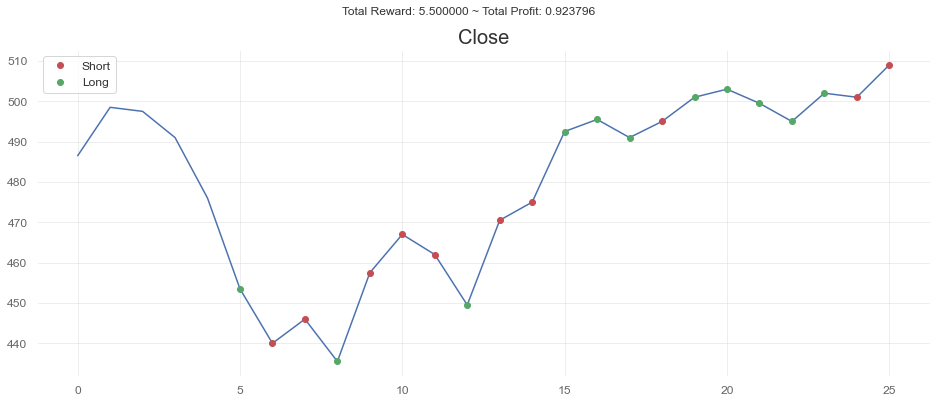

In [13]:
plt.figure(figsize=(16, 6))
env.render_Close()#將「環境」畫出來

↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(未含手續費) ↓↓↓


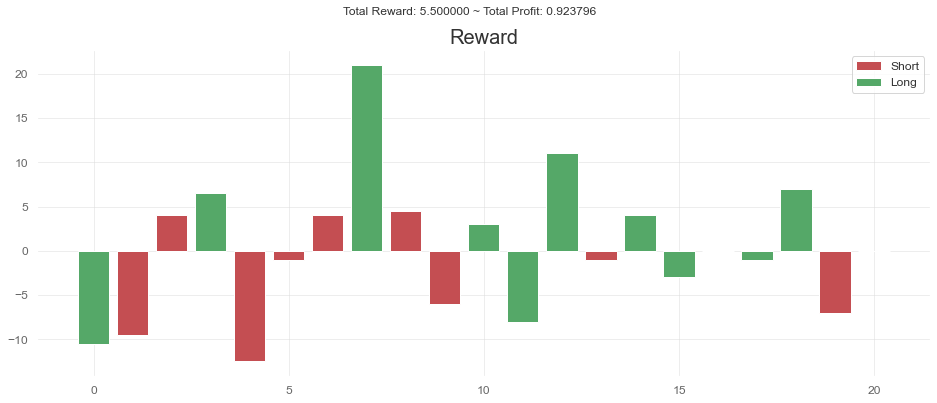

In [14]:
plt.figure(figsize=(16, 6))
env.render_Reward()

↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓


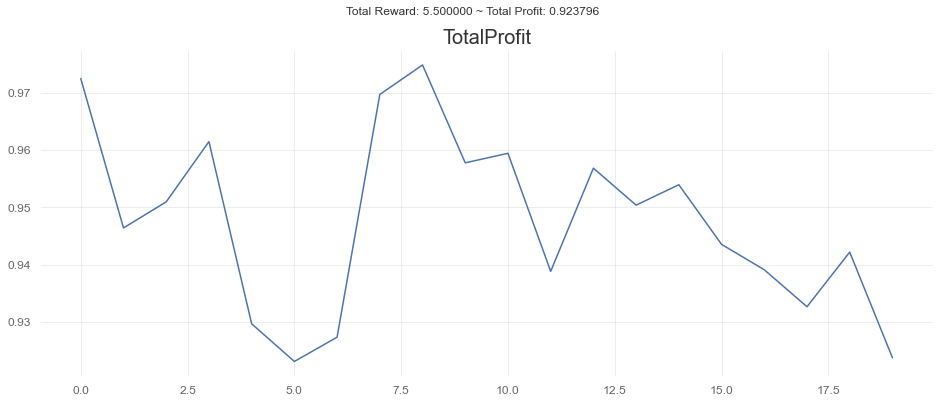

In [15]:
plt.figure(figsize=(16, 6))
env.render_TotalProfit()

# ------------------------------------------------

# 不同技術分析合併進行資料萃取，需要轉換矩陣格式，解釋如下：

In [19]:
# a = np.array([
#     [
#         [1,2,3,4,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6]
#     ]
# ])
# #-----------------------
# b = np.array([
#     [
#         [1,2],[3,4],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ]
# ])
# #-----------------------
# print('目的：將原本矩陣a，變成矩陣b。因為在機器訓練時，需要讓機器意識到為兩組獨立的參數')
# print('注意：入面組嘅大小必須相同，例如[1,2],[3,4]，但不可以[1,2],[3,4,5]\n\n')
# print('第一個數字：大括號\n第二個數字：有四個打橫\n第三個數字：打橫入面有幾多個數字')
# print(a.shape)
# print(a,'\n')
# print('第一個數字：有幾多大組嘅數字\n第二個數字：入面有幾多個小組\n第三個數字：每個小組入面有幾多個數字')
# print(b.shape)
# print(b)